In [115]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

In [116]:
class FaceDetector:
    def __init__(self):
        self.cascade_classifier = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )
        self.landmark_model = cv2.face.createFacemarkLBF()
        self.landmark_model.loadModel("lbfmodel.yaml")

    def detect(self, img_path: str) -> Tuple[np.ndarray, List[np.ndarray], List[Tuple[int, int]], List[np.ndarray]]:
        """
        detects faces and facial landmarks in an image, and highlights them on a copy of the image

        in:
            img_path (str): path to the input image file

        out:
            img_rgb (np.ndarray): rgb image with face boxes, centers, and landmarks drawn
            face_rectangles (list[np.ndarray]): list of rectangles in (x, y, w, h) format for each detected face
            face_centers (list[tuple[int, int]]): center coordinates of each detected face as (x, y) tuples
            landmarks_all_faces (list[np.ndarray]): list of arrays containing 68 (x, y) facial landmark points per face
        """
        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img_read, cv2.COLOR_GRAY2RGB)

        face_rectangles = self.cascade_classifier.detectMultiScale(
            img_rgb, scaleFactor=1.1, minNeighbors=5
        )
        face_centers: List[Tuple[int, int]] = []

        for (x, y, width, height) in face_rectangles:
            cv2.rectangle(img_rgb, (x, y), (x + width, y + height), (0, 255, 0), 2)

            center_x, center_y = x + (width // 2), y + (height // 2)
            cv2.circle(img_rgb, (center_x, center_y), 3, (0, 0, 255), -1)

            face_centers.append((center_x, center_y))

        _, landmarks_all_faces = self.landmark_model.fit(img_read, face_rectangles)
        landmarks_all_faces = [landmarks[0] for landmarks in landmarks_all_faces]

        for landmarks_face in landmarks_all_faces:
            for (x, y) in landmarks_face:
                cv2.circle(img_rgb, (int(x), int(y)), 1, (255, 0, 0), -1)

        return img_rgb, list(face_rectangles), face_centers, landmarks_all_faces

    def display(self, img_rgb: np.ndarray) -> None:
        """
        displays an rgb image using matplotlib

        in:
            img_rgb (np.ndarray): rgb image to display
        """
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()


In [117]:
class MaskHandler:
    def mask_points(self, img_path: str, landmarks: List[np.ndarray]) -> Tuple[np.ndarray, List[List[Tuple[int, int]]]]:
        """
        selects specific facial landmarks and highlights them on the image

        in:
            img_path (str): path to the input image file
            landmarks (list[np.ndarray]): list of 68-point landmarks for each detected face

        out:
            img_rgb (np.ndarray): rgb image with selected landmark points highlighted
            selected_pts (list[list[tuple[int, int]]]): list of selected (x, y) points per face
        """
        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img_read, cv2.COLOR_GRAY2RGB)

        idxs = [18, 25, 48, 54, 36, 45, 51]

        selected_pts: List[List[Tuple[int, int]]] = []
        for lm in landmarks:
            face_pts = []
            for i in idxs:
                x, y = lm[i]
                face_pts.append((int(x), int(y)))
                cv2.circle(img_rgb, (int(x), int(y)), 3, (0, 255, 255), -1)
            selected_pts.append(face_pts)

        return img_rgb, selected_pts

    def display_mask(self, img_path: str, mask_pts: List[List[Tuple[int, int]]]) -> None:
        """
        applies a convex mask to selected facial regions and displays the result

        in:
            img_path (str): path to the original grayscale image
            mask_pts (list[list[tuple[int, int]]]): list of (x, y) coordinates to form convex hulls for each face
        """
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_original_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

        mask = np.zeros(img_gray.shape, dtype=np.uint8)
        for face_polygon in mask_pts:
            polygon = np.array(face_polygon, dtype=np.int32)
            hull = cv2.convexHull(polygon)
            cv2.fillPoly(mask, [hull], color=255)

        masked_rgb = cv2.bitwise_and(img_original_rgb, img_original_rgb, mask=mask)

        plt.imshow(masked_rgb)
        plt.axis('off')
        plt.show()


In [118]:
class SuperpixelFeatureExtractor:
    def __init__(self, region_size: int = 10, neighborhood_size: int = 3):
        """
        initializes the superpixel feature extractor with specified region and neighborhood sizes

        in:
            region_size (int): size of the superpixel region
            neighborhood_size (int): size of the neighborhood for entropy calculation
        """
        self.region_size = region_size
        self.neighborhood_size = neighborhood_size
        self.algorithm = cv2.ximgproc.SLIC 

    def get_slic_superpixels(self, img_path: str) -> Tuple[cv2.ximgproc.SuperpixelSLIC, np.ndarray, np.ndarray, int]:
        """
        computes superpixels using the SLIC algorithm and returns the results

        in:
            img_path (str): path to the input image file

        out:
            slic (cv2.ximgproc.SuperpixelSLIC): SLIC superpixel object
            contoured_img (np.ndarray): RGB image with superpixel contours overlaid
            labels (np.ndarray): array of superpixel labels for each pixel
            num_superpixels (int): number of superpixels detected
        """
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        slic = cv2.ximgproc.createSuperpixelSLIC(
            img_rgb, algorithm=self.algorithm, region_size=self.region_size
        )
        slic.iterate(10)

        contour_mask = slic.getLabelContourMask()

        contour_colored_mask = np.zeros_like(img_rgb)
        contour_colored_mask[contour_mask == 255] = [0, 0, 255]

        contoured_img = cv2.addWeighted(img_rgb, 1, contour_colored_mask, 1, 0)

        return slic, contoured_img, slic.getLabels(), slic.getNumberOfSuperpixels()

    def basic_superpixel_features(self, img_path: str, slic_superpixels: cv2.ximgproc.SuperpixelSLIC) -> List[dict]:
        """
        extracts basic features (mean intensity, std intensity, entropy) for each superpixel

        in:
            img_path (str): path to the input image file
            slic_superpixels (cv2.ximgproc.SuperpixelSLIC): the precomputed SLIC superpixel object

        out:
            features (list[dict]): list of feature dictionaries for each superpixel, containing:
                - label (int): superpixel label
                - mean_intensity (float): mean intensity of the superpixel
                - std_intensity (float): standard deviation of the intensity
                - entropy (float): entropy of the intensity distribution within the superpixel
        """
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        features: List[dict] = []

        labels = slic_superpixels.getLabels()
        unique_labels = np.unique(labels)

        for label in unique_labels:
            superpixel_pixels = img[labels == label]
            mean_intensity = np.mean(superpixel_pixels)
            std_intensity = np.std(superpixel_pixels)

            entropy_map = np.zeros_like(img, dtype=float)

            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    r = self.neighborhood_size

                    x_min, x_max = max(i - r, 0), min(i + r + 1, img.shape[0])
                    y_min, y_max = max(j - r, 0), min(j + r + 1, img.shape[1])
                    neighborhood = img[x_min:x_max, y_min:y_max]

                    hist, _ = np.histogram(neighborhood, bins=256, range=(0, 256), density=True)
                    entropy_map[i, j] = -np.sum(hist * np.log(hist + 1e-7))

            mean_entropy = np.mean(entropy_map[labels == label])

            features.append({
                'label': label,
                'mean_intensity': mean_intensity,
                'std_intensity': std_intensity,
                'entropy': mean_entropy
            })

        return features

    def display_superpixels(self, contoured_img: np.ndarray) -> None:
        """
        displays an RGB image with superpixel contours using matplotlib

        in:
            contoured_img (np.ndarray): RGB image with overlaid superpixel contours
        """
        plt.imshow(contoured_img)
        plt.axis('off')
        plt.show()


num faces detected: 9
face centers: [(np.int32(49), np.int32(84)), (np.int32(418), np.int32(115)), (np.int32(104), np.int32(107)), (np.int32(247), np.int32(120)), (np.int32(483), np.int32(110)), (np.int32(566), np.int32(95)), (np.int32(182), np.int32(119)), (np.int32(201), np.int32(86)), (np.int32(332), np.int32(101))]
landmark array shapes: [(68, 2), (68, 2), (68, 2), (68, 2), (68, 2), (68, 2), (68, 2), (68, 2), (68, 2)]


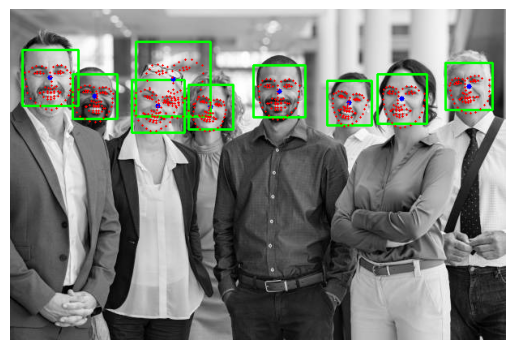

mask points per face: [7, 7, 7, 7, 7, 7, 7, 7, 7]


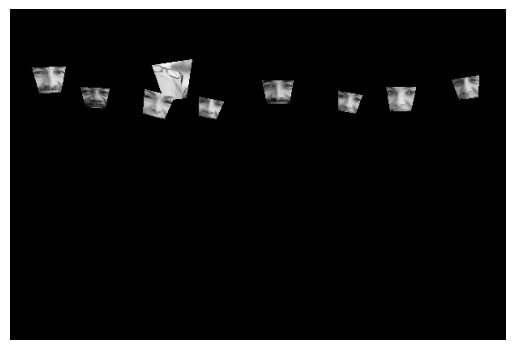

In [119]:
fd = FaceDetector()
mh = MaskHandler()

img_rgb, face_rects, face_centers, landmarks = fd.detect("test_images/faces.jpg")
print("num faces detected:", len(face_rects))
print("face centers:", face_centers)
print("landmark array shapes:", [lm.shape for lm in landmarks])

fd.display(img_rgb)

img_masked, mask_pts = mh.mask_points("test_images/faces.jpg", landmarks)
print("mask points per face:", [len(pts) for pts in mask_pts])

mh.display_mask("test_images/faces.jpg", mask_pts)

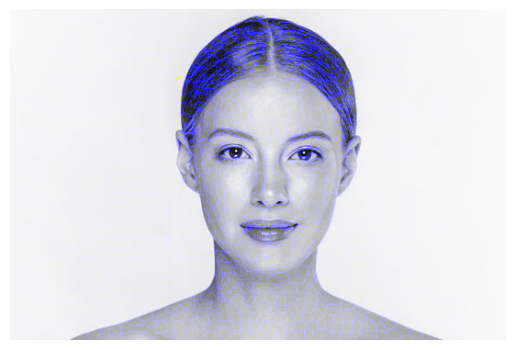

360 1944


In [120]:
test_image_path = 'test_images/face.jpg'

extractor = SuperpixelFeatureExtractor(region_size=10)

slic, contoured_img, labels, num = extractor.get_slic_superpixels(test_image_path)

extractor.display_superpixels(contoured_img)
print(len(labels), num)


SLIC superpixel object: < cv2.ximgproc.SuperpixelSLIC 000001C50238F030>
Number of superpixels: 216
Labels shape: (360, 540)
Contoured image shape: (360, 540, 3)


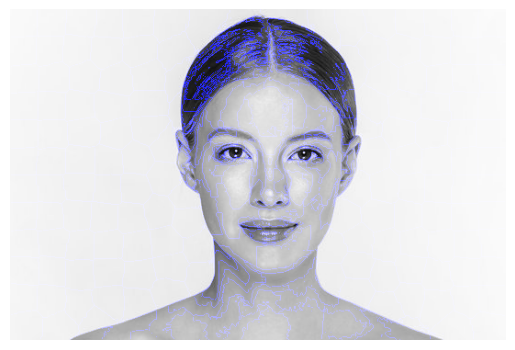

KeyboardInterrupt: 

In [ ]:
test_image_path = 'test_images/face.jpg'

sfe = SuperpixelFeatureExtractor(region_size=30, neighborhood_size=1)

slic, contoured_img, labels, num_superpixels = sfe.get_slic_superpixels(test_image_path)

print(f"SLIC superpixel object: {slic}")
print(f"Number of superpixels: {num_superpixels}")
print(f"Labels shape: {labels.shape}")
print(f"Contoured image shape: {contoured_img.shape}")

sfe.display_superpixels(contoured_img)

features = sfe.basic_superpixel_features(test_image_path, slic)
print("Extracted superpixel features:")
for feature in features[:5]:
    print(feature)
